In [33]:
import numpy as np
import pandas as pd
import databento as db
import scipy.stats as stats
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

plt.style.use('seaborn-v0_8')
sns.set_palette("husl")

### Load trades

In [7]:
def db_preparing(path: str) -> pd.DataFrame:
    store = db.DBNStore.from_file(path)
    df = store.to_df()
    df = df.reset_index(drop=True)
    trades = df[['ts_event', 'side', 'depth', 'price', 'size']]
    trades['ts_event'] = pd.to_datetime(trades['ts_event'].astype('int64'))
    trades = trades.set_index('ts_event')
    return trades

In [9]:
def resampling(path: str) -> pd.DataFrame:
    trades = db_preparing(path)
    sides = ['A', 'B', 'N']
    res_trds = []
    for side in sides:
        side_trades = trades[trades['side'] == f'{side}']
        resampled_trades = side_trades.resample("100ms").agg({"price": "mean", "size": "sum", "depth": "max"}).fillna(0)
        res_trds.append(resampled_trades['price'])
        res_trds.append(resampled_trades['size'])
    resampled_depth = trades['depth'].resample("100ms").max().fillna(0)
    res_trds.append(resampled_depth)
    trades_resampled = pd.DataFrame(res_trds).T
    trades_resampled = trades_resampled.fillna(0)
    trades_resampled.columns = ['trade_price_A', 'trade_volume_A', 'trade_price_B', 'trade_volume_B', 'trade_price_N', 'trade_volume_N', 'depth']
    return trades_resampled

In [11]:
def load_trades(dates):
    dataframes = {}
    for date in dates:
        for asset in ['QQQ', 'SPY', 'FAST', 'MRVL', 'VRSK', 'VXX', 'ANSS']:
            path = f'C:/Users/Эвелина Новикова/Downloads/xnas-itch-{date}.trades.{asset}.dbn.zst'
            dataframe = resampling(path)
            dataframe[f'volume_{asset}'] = dataframe['trade_volume_A'] + dataframe['trade_volume_B'] + dataframe['trade_volume_N']
            dataframes[f'{asset}_{date}'] = pd.DataFrame({f'volume_{asset}': dataframe[f'volume_{asset}']})
    return dataframes

In [13]:
dates = [20250625, 20250626, 20250627, 20250630, 20250701, 20250702, 20250703]
trades = load_trades(dates)

### Trades preparation

In [14]:
def make_combined_trades(date):
    combined_trades = trades[f'VXX_{date}'].join(trades[f'SPY_{date}'], how='outer')\
           .join(trades[f'QQQ_{date}'], how='outer')\
           .join(trades[f'MRVL_{date}'], how='outer')\
           .join(trades[f'ANSS_{date}'], how='outer')\
           .join(trades[f'FAST_{date}'], how='outer')\
           .join(trades[f'VRSK_{date}'], how='outer')
    return combined_trades

In [15]:
combined_trades_20250625 = make_combined_trades(20250625)
combined_trades_20250626 = make_combined_trades(20250626)
combined_trades_20250627 = make_combined_trades(20250627)
combined_trades_20250630 = make_combined_trades(20250630)
combined_trades_20250701 = make_combined_trades(20250701)
combined_trades_20250702 = make_combined_trades(20250702)
combined_trades_20250703 = make_combined_trades(20250703)

In [16]:
def regular_trades(combined_trades):
    combined_trades = combined_trades.reset_index()
    combined_trades['ts_event'] = pd.to_datetime(combined_trades['ts_event'])
    filtered_trades = combined_trades[(combined_trades['ts_event'].dt.time >= pd.to_datetime('13:35:00').time()) 
                 & (combined_trades['ts_event'].dt.time < pd.to_datetime('19:55:00').time())]
    filtered_trades = filtered_trades.rename(columns={'ts_event': 'datetime'})
    return filtered_trades

In [19]:
trades_20250625 = regular_trades(combined_trades_20250625)
trades_20250626 = regular_trades(combined_trades_20250626)
trades_20250627 = regular_trades(combined_trades_20250627)
trades_20250630 = regular_trades(combined_trades_20250630)
trades_20250701 = regular_trades(combined_trades_20250701)
trades_20250702 = regular_trades(combined_trades_20250702)
trades_20250703 = regular_trades(combined_trades_20250703)

In [23]:
concatenated_trades = pd.concat([trades_20250625, trades_20250626, trades_20250627, trades_20250630, trades_20250701,
                                 trades_20250702, trades_20250703])
concatenated_trades = concatenated_trades.set_index('datetime').fillna(0)

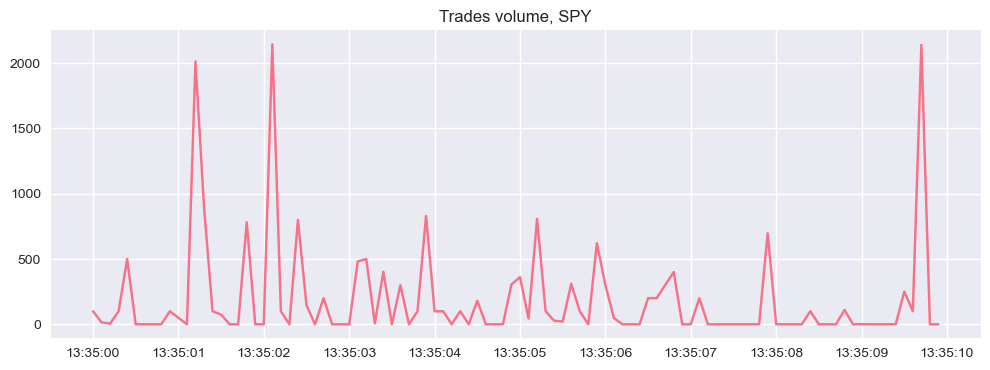

In [137]:
plt.figure(figsize=(12, 4))
plt.plot(concatenated_trades['volume_SPY'][:100])
plt.title('Trades volume, SPY')
plt.grid(True)
plt.show()

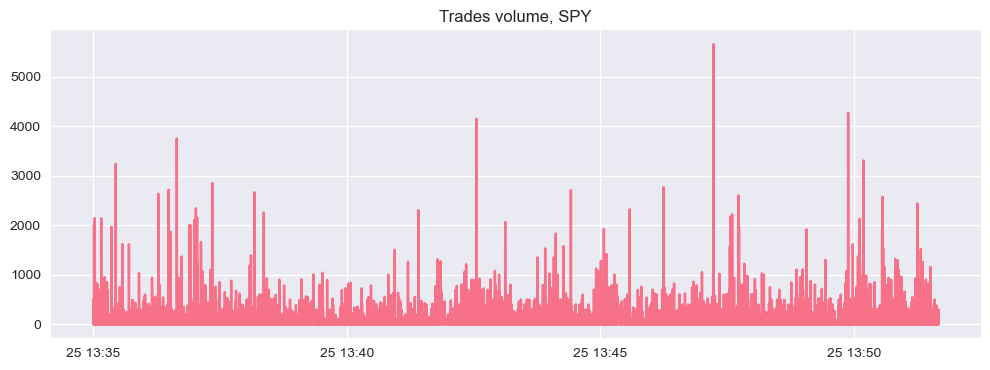

In [139]:
plt.figure(figsize=(12, 4))
plt.plot(concatenated_trades['volume_SPY'][:10000])
plt.title('Trades volume, SPY')
plt.grid(True)
plt.show()

## Гипотеза: в 00 минут каждого часа объёмы торгов возрастают.

### Сравниваем торги на диапазоне __:59 - __:01 каждого часа и вне этого диапазона

In [51]:
def t_test_1m(col):
    data = concatenated_trades[[col]].copy()
    data["ts_event"] = data.index
    mask_peak = ((data["ts_event"].dt.minute >= 59) | (data["ts_event"].dt.minute <= 1))

    x = data.loc[mask_peak, col]
    y = data.loc[~mask_peak, col]

    t_stat, p_value = stats.ttest_ind(x, y)
    if p_value < 0.05:
        result = 'Reject equality'
    else:
        result = 'Not reject equality'

    return result

In [57]:
results_1m = []
for col in concatenated_trades.columns:
    result = t_test_1m(col)
    results_1m.append({col: result})

In [59]:
results_1m

[{'volume_VXX': 'Reject equality'},
 {'volume_SPY': 'Reject equality'},
 {'volume_QQQ': 'Reject equality'},
 {'volume_MRVL': 'Reject equality'},
 {'volume_ANSS': 'Reject equality'},
 {'volume_FAST': 'Reject equality'},
 {'volume_VRSK': 'Reject equality'}]

### Сравниваем торги на диапазоне __:55 - __:05 каждого часа и вне этого диапазона

In [61]:
def t_test_5m(col):
    data = concatenated_trades[[col]].copy()
    data["ts_event"] = data.index
    mask_peak = ((data["ts_event"].dt.minute >= 55) | (data["ts_event"].dt.minute <= 5))

    x = data.loc[mask_peak, col]
    y = data.loc[~mask_peak, col]

    t_stat, p_value = stats.ttest_ind(x, y)
    if p_value < 0.05:
        result = 'Reject equality'
    else:
        result = 'Not reject equality'

    return result

In [63]:
results_5m = []
for col in concatenated_trades.columns:
    result = t_test_5m(col)
    results_5m.append({col: result})

In [65]:
results_5m

[{'volume_VXX': 'Reject equality'},
 {'volume_SPY': 'Reject equality'},
 {'volume_QQQ': 'Reject equality'},
 {'volume_MRVL': 'Not reject equality'},
 {'volume_ANSS': 'Reject equality'},
 {'volume_FAST': 'Reject equality'},
 {'volume_VRSK': 'Reject equality'}]

### Сравниваем торги на диапазоне __:50 - __:10 каждого часа и вне этого диапазона

In [79]:
def t_test_10m(col):
    data = concatenated_trades[[col]].copy()
    data["ts_event"] = data.index
    mask_peak = ((data["ts_event"].dt.minute >= 50) | (data["ts_event"].dt.minute <= 10))

    x = data.loc[mask_peak, col]
    y = data.loc[~mask_peak, col]

    t_stat, p_value = stats.ttest_ind(x, y)
    if p_value < 0.05:
        result = 'Reject equality'
    else:
        result = 'Not reject equality'

    return result

In [81]:
results_10m = []
for col in concatenated_trades.columns:
    result = t_test_10m(col)
    results_10m.append({col: result})

In [82]:
results_10m

[{'volume_VXX': 'Reject equality'},
 {'volume_SPY': 'Reject equality'},
 {'volume_QQQ': 'Reject equality'},
 {'volume_MRVL': 'Not reject equality'},
 {'volume_ANSS': 'Reject equality'},
 {'volume_FAST': 'Reject equality'},
 {'volume_VRSK': 'Reject equality'}]

### Сравниваем торги на диапазоне __:45 - __:15 каждого часа и вне этого диапазона

In [85]:
def t_test_15m(col):
    data = concatenated_trades[[col]].copy()
    data["ts_event"] = data.index
    mask_peak = ((data["ts_event"].dt.minute >= 45) | (data["ts_event"].dt.minute <= 15))

    x = data.loc[mask_peak, col]
    y = data.loc[~mask_peak, col]

    t_stat, p_value = stats.ttest_ind(x, y)
    if p_value < 0.05:
        result = 'Reject equality'
    else:
        result = 'Not reject equality'

    return result

In [87]:
results_15m = []
for col in concatenated_trades.columns:
    result = t_test_15m(col)
    results_15m.append({col: result})

In [89]:
results_15m

[{'volume_VXX': 'Reject equality'},
 {'volume_SPY': 'Reject equality'},
 {'volume_QQQ': 'Reject equality'},
 {'volume_MRVL': 'Not reject equality'},
 {'volume_ANSS': 'Not reject equality'},
 {'volume_FAST': 'Not reject equality'},
 {'volume_VRSK': 'Reject equality'}]

### Сравниваем торги на диапазоне __:40 - __:20 каждого часа и вне этого диапазона

In [105]:
def t_test_20m(col):
    data = concatenated_trades[[col]].copy()
    data["ts_event"] = data.index
    mask_peak = ((data["ts_event"].dt.minute >= 40) | (data["ts_event"].dt.minute <= 20))

    x = data.loc[mask_peak, col]
    y = data.loc[~mask_peak, col]

    t_stat, p_value = stats.ttest_ind(x, y)
    if p_value < 0.05:
        result = 'Reject equality'
    else:
        result = 'Not reject equality'

    return result

In [107]:
results_20m = []
for col in concatenated_trades.columns:
    result = t_test_20m(col)
    results_20m.append({col: result})

In [109]:
results_20m

[{'volume_VXX': 'Reject equality'},
 {'volume_SPY': 'Reject equality'},
 {'volume_QQQ': 'Reject equality'},
 {'volume_MRVL': 'Not reject equality'},
 {'volume_ANSS': 'Not reject equality'},
 {'volume_FAST': 'Not reject equality'},
 {'volume_VRSK': 'Not reject equality'}]

Вывод: наши данные не опровергают тот факт, что в 00 минут каждого часа объёмы торгов возрастают. Кроме того, можно заметить, что для более ликвидных активов скачок объёма торгов начинается сильно раньше и заканчивается сильно позже нуля минут, чем для активов с низкой ликвидностью.